In [1]:
# Import required packages
import pandas as pd 
from datetime import datetime as dt
from dateutil import tz
import re
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

# Prepare data

In [2]:
# Import data
data=pd.read_excel('Summer Camp Task Data.xlsx')

# change created_at column from timestamp to datetime
data['created_at']=pd.to_datetime(data['created_at'],unit='ms')
data['created_at']=data['created_at']+pd.Timedelta('03:30:00') # add 3:30 hour in order to show times in Iran timezone

# Add columns which contain tokens in list instead of string (for further analysis).
data['tokens_list']=data['tokens'].apply(lambda x:re.sub('[\[|\]| ]','',x).split(',') if not pd.isna(x) else np.NaN)

# Information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111083 entries, 0 to 111082
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   action                   111083 non-null  object        
 1   created_at               111083 non-null  datetime64[ns]
 2   source_event_id          111083 non-null  object        
 3   device_id                109596 non-null  object        
 4   post_page_offset         35287 non-null   float64       
 5   tokens                   35287 non-null   object        
 6   post_index_in_post_list  75796 non-null   float64       
 7   post_token               75795 non-null   object        
 8   tokens_list              35287 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 7.6+ MB


In [3]:
# Show 2 row of data
data.head(2)

,action,created_at,source_event_id,device_id,post_page_offset,tokens,post_index_in_post_list,post_token,tokens_list
0,load_post_page,2021-01-02 03:20:01.150,1575558c-a702-46ef-8e18-bc5cef761473,Ed9EADRZRXCHcrcEP_Hnkg,26.0,"[wXvP3enu, wXvHXzUS, wXvPHXVe, wXvPHRs3, wXvH3...",NaN,NaN,"[wXvP3enu, wXvHXzUS, wXvPHXVe, wXvPHRs3, wXvH3..."
1,load_post_page,2021-01-02 03:22:01.641,0fd004f4-ce9b-4766-ac96-7578dedebacb,5aVIp_PNSAWxqwBETYpmxQ,19.0,"[wXujANbk, wXurAJsf, wXufwlh1, wXtr_4tD, wXujg...",NaN,NaN,"[wXujANbk, wXurAJsf, wXufwlh1, wXtr_4tD, wXujg..."


<div style="direction:rtl;line-height:200%;font-size:14px;font-family:B Nazanin;">

    • action:  اکشن انجام شده توسط کاربر، حاوی یکی از مقادیر load_post_page یا click_post
    • created_at: زمان وقوع اکشن با فرمت timestamp و با دقت میلی ثانیه
    • source_event_id: شناسه یکتای هر کوئری
    • device_id: شناسه یکتای هر کاربر
    • post_page_offset: شماره لیست لود شده (مربوط به اکشن load_post_page)
    • tokens: لیست شناسه آگهی‌های لود شده (مربوط به اکشن load_post_page)
    • post_index_in_post_list: رتبه آگهی در لیست (مربوط به اکشن click_post)
    • post_token: شناسه یکتای آگهی کلیک شده (مربوط به اکشن click_post)
 
</div>


In [4]:
# Define some essential subset of data
load_post=data[data['action']=='load_post_page']
click_post=data[data['action']=='click_post']
query_grouper=lambda x:x.groupby('source_event_id')

# Tasks


<div style="direction:rtl;line-height:200%;font-family:B Nazanin">
    <h2>مسئله اول: پیدا کردن خطا در داده ها  </h2>
</div>

<div style="direction:rtl;line-height:200%;font-size:18px;font-family:B Nazanin">
    <b> مورد اول :</b>  تعداد 123 رکورد دیتا از روز بعد وقبل موجود است در صورتی که دیتا فقط باید مربوط به یک روز باشد.
</div>

In [5]:
# `jan2` specifies data which created at 2021-01-02 (This Find by manual search in data) 
jan2=data['created_at'].apply(lambda x:x.day==2 and x.month==1 and x.year==2021)

# `not_jan2` specifies data which created at date except 2021-01-02  
not_jan2=data[data.index.isin(jan2[jan2==False].index)].sort_values(by='created_at')

not_jan2.head(2)

,action,created_at,source_event_id,device_id,post_page_offset,tokens,post_index_in_post_list,post_token,tokens_list
26178,load_post_page,2021-01-01 04:06:09.213,1fc5ef66-aaad-4cf5-8e36-1e974de66fdf,lJgu0b3FQG6_grFbXenl2Q,0.0,"[wXtbOKF-, wXtLeB6p, wXpbfeIJ, wXt38PoX, wXt7K...",NaN,NaN,"[wXtbOKF-, wXtLeB6p, wXpbfeIJ, wXt38PoX, wXt7K..."
56013,load_post_page,2021-01-01 04:06:18.164,79910930-7296-4342-ae09-8e55e4803940,lJgu0b3FQG6_grFbXenl2Q,0.0,"[wXvPByYA, wXmHw9qd, wXsPnrBu, wXsTzSjv, wXrXX...",NaN,NaN,"[wXvPByYA, wXmHw9qd, wXsPnrBu, wXsTzSjv, wXrXX..."


<div style="direction:rtl;line-height:200%;font-size:18px;font-family:B Nazanin">
    <b> مورد دوم : </b>
    تعدادی هم از device_id دی ها NaN هستن که خطا به حساب میاد و مشخص بودنشون مهمه.
</div>

In [6]:
# dev_id_err find device_id which are NaN
dev_id_err=data[data['device_id'].apply(lambda x:pd.isna(x))]
dev_id_err.head(2)

,action,created_at,source_event_id,device_id,post_page_offset,tokens,post_index_in_post_list,post_token,tokens_list
30,load_post_page,2021-01-02 03:14:03.099,1f7d05a1-a65d-40d5-b0c7-8aa7c9904052,NaN,30.0,"[wXqHuuPP, wXqD-7ES, wXq_dCXM, wXqvtwYd, wXqTN...",NaN,NaN,"[wXqHuuPP, wXqD-7ES, wXq_dCXM, wXqvtwYd, wXqTN..."
49,load_post_page,2021-01-02 03:55:32.858,b3c190ef-94c0-4983-ac18-6fea54a89b22,NaN,0.0,"[wXvnV_cv, wXv3VGI6, wXvP2oHU, wXv_ji--, wXvb3...",NaN,NaN,"[wXvnV_cv, wXv3VGI6, wXvP2oHU, wXv_ji--, wXvb3..."


In [7]:
print(f'{len(dev_id_err)/len(data)*100} percent of device ids (non unique) are NaN')

1.338638675584923 percent of device ids (non unique) are NaN


<div style="direction:rtl;line-height:200%;font-size:18px;font-family:B Nazanin">
    <b> مورد سوم: </b>
    67 مورد تکراری در داده ها وجود دارد
</div>

In [8]:
# Find duplicate data in dataset
data[data.duplicated(['action','created_at','device_id','tokens','post_token'],False)].sort_values(by=['action','created_at','device_id'])

,action,created_at,source_event_id,device_id,post_page_offset,tokens,post_index_in_post_list,post_token,tokens_list
28438,click_post,2021-01-02 02:54:24.436,6435c8c1-2730-4b5e-9a7a-9fcfafaf5850,hUr_sb5vSXywHppL0H6TSw,NaN,NaN,38.0,wXbLLkFL,NaN
58648,click_post,2021-01-02 02:54:24.436,6435c8c1-2730-4b5e-9a7a-9fcfafaf5850,hUr_sb5vSXywHppL0H6TSw,NaN,NaN,38.0,wXbLLkFL,NaN
26500,click_post,2021-01-02 03:00:05.655,5271b7ce-100d-4535-a181-546c3d31a595,MFwbG09bT62l3ceGbvlnVg,NaN,NaN,29.0,wXu3PAgJ,NaN
61728,click_post,2021-01-02 03:00:05.655,5271b7ce-100d-4535-a181-546c3d31a595,MFwbG09bT62l3ceGbvlnVg,NaN,NaN,29.0,wXu3PAgJ,NaN
21878,click_post,2021-01-02 03:00:18.555,a3ebe70c-9e8a-44d3-8669-182e070b5389,CYUl891uSPyJAvQYxD7qkg,NaN,NaN,31.0,wXvPGQqA,NaN
...,...,...,...,...,...,...,...,...,...
62658,load_post_page,2021-01-02 03:57:40.645,005d3801-cbd8-4432-be02-3b85c10f6938,B6zlz5mbRlWt5fDOaigdMQ,0.0,[wXg7l0c1],NaN,NaN,[wXg7l0c1]
56014,load_post_page,2021-01-02 03:58:31.349,1153104c-b735-4ad2-952e-313392f0d8c6,mGOhD4hpQd6iTwWNB6c3DA,3.0,"[wXvzwHFY, wXvvQzGP, wXvvQnsx, wXvTg-fL, wXu7_...",NaN,NaN,"[wXvzwHFY, wXvvQzGP, wXvvQnsx, wXvTg-fL, wXu7_..."
85187,load_post_page,2021-01-02 03:58:31.349,1153104c-b735-4ad2-952e-313392f0d8c6,mGOhD4hpQd6iTwWNB6c3DA,3.0,"[wXvzwHFY, wXvvQzGP, wXvvQnsx, wXvTg-fL, wXu7_...",NaN,NaN,"[wXvzwHFY, wXvvQzGP, wXvvQnsx, wXvTg-fL, wXu7_..."
92186,load_post_page,2021-01-02 03:58:49.915,1153104c-b735-4ad2-952e-313392f0d8c6,mGOhD4hpQd6iTwWNB6c3DA,4.0,"[wXg3ZS37, wXurdgdU, wXujtkqr, wXujtWrQ, wXuL9...",NaN,NaN,"[wXg3ZS37, wXurdgdU, wXujtkqr, wXujtWrQ, wXuL9..."


<div style="direction:rtl;line-height:200%;font-size:18px;font-family:B Nazanin">
    <b> مورد چهارم: </b>
    <div>
        کاربر وقتی روی یک پست کلیک میکنه باید قبل از اون، اون پست رو لود کرده باشد. پس یعنی برای هر source_event_id وقتی یک اکشن click_post داریم حتما باید  load_post_page هم داشته باشیم. اما در تعدادی اینطوری نیست و این با منطق سرچ در اپلیکشن دیوار مطابق نیست.
    </div>
</div>

In [9]:
# Find source_event_id s which have click_post but no post_load_page
# Group data in order to find click no load 
click_no_load_gp=query_grouper(data).agg({'action':lambda x:x.isin(['click_post']).any() and not x.isin(['load_post_page']).any()})
click_no_load_gp=click_no_load_gp.rename(columns={'action':'have post_click but no load_post_page'})

# Create mask 
click_no_load_mask=click_no_load_gp['have post_click but no load_post_page']

click_no_load_gp[click_no_load_mask]


,have post_click but no load_post_page
source_event_id,
00142c59-745c-4004-a955-698ddcf1faa6,True
0016f59f-9fb3-4ab5-ae78-9783314b81fc,True
0017b9ef-5903-40f9-a219-85728eb78436,True
00240c5c-9d06-4fcd-93f5-93b842fdab63,True
0036112e-03f7-4175-ba32-be852dcad535,True
...,...
ffb9411d-9e93-4fc0-bf71-82abe7539f7b,True
ffcc7cd6-2678-46de-8b25-9d796ad095f1,True
ffdd48fc-4c05-4c75-bf8c-5cd42729d2b8,True


<div style="direction:rtl;line-height:200%;font-size:18px;font-family:B Nazanin">
    <b> مورد پنجم: </b>
    <div>
        وقتی کاربر در اپلیکیشن سرچ میکنه باید همه آگهی هایی که روی اون ها کلیک شده در لیست آگهی های لود شده باشه. واگر نباشه در این دیتا ست و برای این تسک باید خطا در نظر گرفت چون این اکشن ها حتی اگر خطا نباشند احتمالا در بخش سرچ دیوار انجام نشدن.
    </div>
</div>

In [10]:
def tokens_lister(tokens_series):
    '''
    Get series of tokens_list as input and output all tokens in one list
    
    Parameters
    ----------
    tokens_series: pandas.Series
        Series contain subset of tokens_list 

    Returns
    -------
    tokens_list : list
        list of all non-NaN tokens in tokens_series
    '''
    # Filter non-NaN series
    tokens_series_not_nan=tokens_series[~pd.isna(tokens_series)]
    tokens_list=[]
    
    # Add each token in tokens_series to tokens_list
    for tokens in tokens_series_not_nan:
        tokens_list+=tokens
        
    return tokens_list

def click_lister(click_series):
    '''
    Give series of post_token as input and output all post_tokens in one list
    
    Parameters
    ----------
    click_series : pandas.Series
        Series contain subset of post_token
        
    Returns
    -------
    click_list : list
        list of all non-NaN tokens in post_token        
    '''
    # Filter non-NaN series
    click_series_not_nan=click_series[~pd.isna(click_series)]
    click_list=[]
    
    # Add each token in click_series to click_list
    for click in click_series_not_nan:
        click_list.append(click)
        
    return click_list


# Exclude data wich have click in query but no load
click_with_load_df=data[data['source_event_id'].isin(click_no_load_mask[~click_no_load_mask].index)]

# Group click_with_load_df with source_event_id in order to find unloaded click
unloaded_click_gp=query_grouper(click_with_load_df).agg({'tokens_list':tokens_lister,'post_token':click_lister})

# Create mask in order to find unloaded click
unloaded_click_mask=unloaded_click_gp.apply(lambda x:pd.Series(x['post_token']).isin(x['tokens_list']).all(),axis=1)

# all source_event_id which don't have error
click_no_err=click_no_load_gp[~click_no_load_mask & unloaded_click_mask].index

# all source_event_id which have unloaded clicked post 
unloaded_click_gp[~unloaded_click_mask]


<ipython-input-10-1c790e2d823b>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  unloaded_click_mask=unloaded_click_gp.apply(lambda x:pd.Series(x['post_token']).isin(x['tokens_list']).all(),axis=1)


,tokens_list,post_token
source_event_id,,
013a873e-0039-45fe-93e8-d6880077b6ce,"[wXvDW5Oi, wXvL2e-U, wXvTksZM, wXvL2Scr, wXvP2...","[wXvnUZyU, wXvfVQai, wXv7FCdn, wXvLWmi-, wXv_T..."
014d9325-8d4e-48f1-8179-ca8f0a7ef1c8,"[wXrr49Hl, wXr3HfD6, wXrzW96y, wXrbkM2f, wXrTk...","[wXtbvMYK, wXu_zBDx, wXt3qcMZ]"
02b10b0a-b646-45f9-9463-47e089130f48,"[wXs_kc4s, wXsbkko2, wXsHkzRM, wXsPzT36, wXsny...",[wXsbGmXV]
02fe0981-7ff3-4b71-814b-3026998e08c7,"[wXpXZXez, wXpDZxdO, wXp7nR4d, wXp7BfY2, wXovN...",[wXt7jscc]
03d923b4-19ac-4cbe-9fbb-db2428851790,"[wXvDRxOh, wXvvgR64, wXoTD8sF, wXvrwqnq, wXu7u...","[wXvXxr4T, wXvjy0fh, wXvHyp80, wXvfwcHg, wXvzQ..."
...,...,...
fded6588-eabf-40eb-aaf6-aa6f49c7c19e,"[wXvfi0_W, wXvfCqpH, wXvvgvvN, wXvXicFW, wXm-U...","[wXE7X_9q, wXP_bKro, wXv3y4hh, wXvXyJI3, wXvzi..."
fe4feb43-535a-40d8-b8fc-c0a8218e41e8,"[wXvvXfSd, wXvzH_ye, wXvPp6RN, wXvP5qEz, wXvzX...","[wXvf2RqI, wXvzIiit]"
feba1c20-1912-4ba0-b014-2fc6b4d6649f,"[wXvXajkJ, wXvj5ZIl, wXvDbsrg, wX9KpLO2, wXv3q...",[wXvDr9P1]


<div style="direction:rtl;line-height:200%;font-family:B Nazanin">
    <h2>مسئله دوم: محاسبه کردن متریک ها  </h2>
    <h3> متریک اول : محاسبه dark query percent </h3>
</div>

In [11]:
# Number of unique queries
unique_queries_len=len(data['source_event_id'].value_counts())

# Group load_post by source_event_id and list all tokens in tokens_list
dark_query_gp=query_grouper(load_post).agg({'tokens_list':tokens_lister})

# Mask to find queries have lower than 10 post
dark_query_mask=dark_query_gp['tokens_list'].apply(lambda x:len(x)<10)

dark_query_len=len(dark_query_gp[dark_query_mask])

print(f'{dark_query_len/unique_queries_len*100} % of queries are dark!')

7.960268606603246 % of queries are dark!


<div style="direction:rtl;line-height:200%;font-family:B Nazanin">
    <h3> متریک دوم : محاسبه query bounce rate </h3>
</div>

In [12]:
# data which have no click error in it
data_no_click_err=data[data['source_event_id'].isin(click_no_err)]

# Number of unique queries
unique_queries_len=len(data_no_click_err['source_event_id'].value_counts())

# Group data by source_event_id and flag queries with at least one click as true
query_bounce_gp=query_grouper(data_no_click_err).agg({'action':lambda x:x.isin(['click_post']).any()})

# Number of queries with no click
query_bounce_len=len(query_bounce_gp[query_bounce_gp['action']==False])

print(f'Query Bounce Rate for this queries is : {query_bounce_len/unique_queries_len*100} %')

Query Bounce Rate for this queries is : 38.760035682426405 %


<div style="direction:rtl;line-height:200%;font-family:B Nazanin">
    <h2> مسئله سوم: انتخاب متریک مناسب برای میزان مناسب بودن نتایج برای کاربر  </h2>
</div>

In [13]:
# Create a dataframe include all metric for each query

# We should exclude click_with_no_load and unloaded_click because these metrics need correct_click_df and loaded_click
correct_click_df=data[data['source_event_id'].isin(click_no_err)]

# Calculate Metric 1 
metrics=query_grouper(correct_click_df).agg({'post_index_in_post_list':lambda x:x.min() if not pd.isna(x).all() else 0})
metrics=metrics.rename(columns={'post_index_in_post_list':'Metric 1'})

def tokens_len(tokens):
    '''
    This function exclude nan tokens in series of tokens and return number of all token in it.
    
    Parameters
    ----------
    tokens : pandas.Series
        Series contain subset of tokens_list
    
    Returns
    -------
    integer
        number of all non-NaN token exist in tokens
    '''
    tokens_not_nan=tokens[~pd.isna(tokens)]
    return sum(tokens_not_nan.apply(lambda x:len(x)))
# Calculate Metric 0
click_rate_df=query_grouper(correct_click_df).agg({'action':lambda x:sum(x.isin(['click_post'])),'tokens_list':tokens_len})
click_rate_df=click_rate_df.rename(columns={'action':'number of clicked post','tokens_list':'number of loaded posts'})
click_rate_df['click_rate']=click_rate_df['number of clicked post']/click_rate_df['number of loaded posts']*100
metrics['Metric 0']=click_rate_df['click_rate']

# Calculate Metric 2
metrics['Metric 2']=query_grouper(correct_click_df).agg({'post_index_in_post_list':lambda x:x.mean() if not pd.isna(x).all() else 0})['post_index_in_post_list']

# Calculate Metric 3
metrics['Metric 3']=query_grouper(correct_click_df).agg({'post_index_in_post_list':lambda x:pd.Series([1,2,3]).isin(x.values).any()  if not pd.isna(x).all() else False})['post_index_in_post_list']

# Reorder metrics columns
metrics=metrics[['Metric 0','Metric 1','Metric 2','Metric 3']]

<div style="direction:rtl;line-height:200%;font-size:18px;font-family:B Nazanin">
    <b> Metric 0: </b> درصد آگهی‌های کلیک شده نسبت به آگهی‌های لود شده
    <b> Metric 1: </b> رتبه اولین کلیک کاربر (برای کوئری‌هایی که حداقل یک کلیک داشته‌اند)
    <b> Metric 2: </b>میانگین فاصله بین رتبه کلیک‌های یک کاربر (مثلا اگر کاربر از بین نتایج کوئری روی آگهی‌های دهم و شانزدهم کلیک کند، این متریک برابر ۲/(۶+۱۰) یعنی ۸ خواهد بود)
    <b> Metric 3: </b> اینکه آیا روی یکی از ۳ نتیجه اول کوئری کلیک شده یا نه   
    <div style="direction:rtl;line-height:200%;font-family:B Nazanin">
        مقدار 0 در متریک های 0، 1 و 2 به این معنی  که در این کوئری کلیک انجام نشده است.
    </div>
</div>

In [14]:
metrics.head(3)

,Metric 0,Metric 1,Metric 2,Metric 3
source_event_id,,,,
00049ef3-c027-4f55-869c-46711f0ea0ad,0.000000,0.0,0.00,False
00069dda-4175-4bb0-8ef0-c0e1031d4da6,0.000000,0.0,0.00,False
0017c208-e016-4231-a022-598ba020f1ff,2.380952,2.0,20.75,True


In [15]:
print(f"Mean of Click Rate in all queries : {metrics['Metric 0'].mean()} %")
metrics['Metric 0'].describe()

Mean of Click Rate in all queries : 9.127546407273792 %


count    8968.000000
mean        9.127546
std        19.592342
min         0.000000
25%         0.000000
50%         2.777778
75%         8.898810
max       300.000000
Name: Metric 0, dtype: float64

<div style="direction:rtl;line-height:200%;font-family:B Nazanin">
    <h2>مسئله چهارم:   </h2>
    توضیحات بیشتر در فایل ضمیمه.
    
</div>

In [16]:
# Create binom_df which have probability of sucess(p) and number of trials (n) for each query
binom_df=pd.DataFrame(index=metrics.index)
binom_df['Probability of succsess (p)']=metrics['Metric 0']/100
binom_df['Number of trials (n)']=click_rate_df['number of loaded posts']
binom_df.head(3)

,Probability of succsess (p),Number of trials (n)
source_event_id,,
00049ef3-c027-4f55-869c-46711f0ea0ad,0.00000,24
00069dda-4175-4bb0-8ef0-c0e1031d4da6,0.00000,24
0017c208-e016-4231-a022-598ba020f1ff,0.02381,168


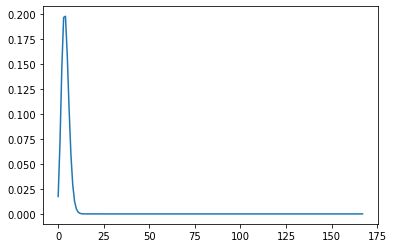

In [18]:
# Plot distribution of selected query 
n=binom_df.iloc[2][1]
p=binom_df.iloc[2][0]
x=np.arange(n)
y=binom.pmf(x,n,p)
plt.plot(x,y)


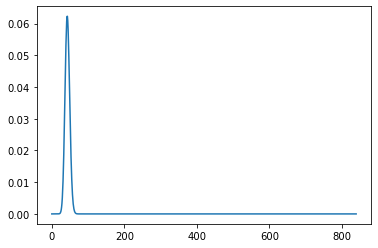

In [17]:
# Plot distribution of selected query 
n=binom_df.loc['ffef6048-9db0-4244-9750-3b530552f0ec','Number of trials (n)']
p=binom_df.loc['ffef6048-9db0-4244-9750-3b530552f0ec','Probability of succsess (p)']
x=np.arange(n)
y=binom.pmf(x,n,p)
plt.plot(x,y)


In [19]:

def any_of_first_3(n,p):
    '''
    This function calculate probability of any sucecess in first three trial in binominal distribution
    
    Parameters
    ----------
    n : int/float
        number of trial in binominal distribution
        
    p : float
        probability of sucecess in binominal distribution
    
    
    Returns
    -------
    Boolean
        True if calculated probability is higher than 0.5 False otherwise.
    '''
    n=int(n)
    m=0
    q=1-p
    for i in range(n-3+1):
         m+=p**i+q**(n-3-i)
    return p*q*q*m+p*p*q*m+p*p*p*m > 0.5

# Create Metric 3_estimate in metrics
metrics['Metric 3_estimate']=binom_df.apply(lambda x:any_of_first_3(x['Number of trials (n)'],x['Probability of succsess (p)']),axis=1)

print(f"If we have metric 0 we can stimate metric 3 with {(metrics['Metric 3']==metrics['Metric 3_estimate']).sum()/len(metrics)*100} accuracy")

If we have metric 0 we can stimate metric 3 with 66.69268510258698 accuracy
